# I'm a Strong Independent Material Scientist and I Don't Need No Sumo
##### Otherwise known as "hear me babble about Julia and learn to plot band structures using code"

# Part 1: Julia

# Some of Julia's History

* First appeared in 2012 (work started in 2009)
* v1.0 was only released 3 years ago (August 2018)
* Currently version 1.6.2
* Very actively developed by v1.0+ is completely stable

# Uses of Julia
1. Julia is already very popular in statistics, data science and bioinformatics (although it is not the standard)
2. Becoming more popular in industry and academia in general
3. More and more prominence in HPC
4. Open-source so many people from Intel, Google, Amazon, IBM, etc. contribute to it.

# Why Julia

1. Julia is written by scientists (and mathematicians), for scientists.
2. It is very easy to learn, as easy as python.
3. Julia has very high performance, and is often as performant as C and Fortran
4. Julia is developed to solve the two language problem.
5. Julia has a rich ecosystem of scientific packages, many of which are state of the art and are unparalleled
6. It has a wonderful and extremely helpful community that values diversity and inclusivity
7. Julia is written in Julia, making it easy to understand
8. It is very easy to develop your own packages 
9. There's a ton of other technical reasons such as its core design design of type stability through specialization via multiple dispatch, but let's not get too technical.

# Part 2: Let's Code!

# Importing Packages and Modules
First, we need to import our libraries

In [34]:
using XMLDict
using Plots
using LinearAlgebra
using LaTeXStrings
using Plots.PlotMeasures

In Julia, we use `using` instead of `import` in `python`. Here is what these packages do:
    
1. `XMLDict.jl`: Reads XML files as a dictionary (makes it easy to parse them)
2. `Plots.jl`: Julia's main plotting library, sort of like `matplotlib` but designed very differently.
3. `LinearAlgebra`: Part of the Julia base library, we need this for some linear algebra operations
4. `LaTeXStrings.jl`: A utility package for writing LaTeX
5. `Plots.PlotMeasures`: A utility module that defines units like "mm", used for setting margins.

# Parsing

Now let's try parsing that `vasprun.xml` file

In [35]:
function parse_xml(path)
    xml_string = open(path) do file
        read(file, String)
    end

    # Read as XML dictionary
    d = xml_dict(xml_string)

    # These are the k-points in an array where each element is a string of 3 numbers
    kpoints = d["modeling"][""][10]["kpoints"]["varray"][1]["v"]
    nk = length(kpoints) # number of k-points
    k = Array{Float64}(undef, 3, nk)
    # Loop over k points and save them into k, in proper float format
    for n in 1:nk
        kpoint = kpoints[n]
        k[:,n] =  map(x->parse(Float64, x),split(kpoint))
    end

    # Access the eigenvalues (and occupations, lol)
    eigenvalues = d["modeling"][""][18]["calculation"]["eigenvalues"]["array"]["set"]["set"]["set"]
    nb = length(eigenvalues[1]["r"]) # Number of bands
    E = Array{Float64}(undef, nb, nk)
    occ = Array{Float64}(undef, nb, nk)
    for n in 1:nk
        for m in 1:nb
            eigenvalue = eigenvalues[n]["r"][m]
            E[m, n] = parse(Float64, split(eigenvalue)[1])
            occ[m, n] = parse(Float64, split(eigenvalue)[2])
        end
    end
    return k, E, occ
end

parse_xml (generic function with 1 method)

## Ploting

Let's try plotting what we have so far

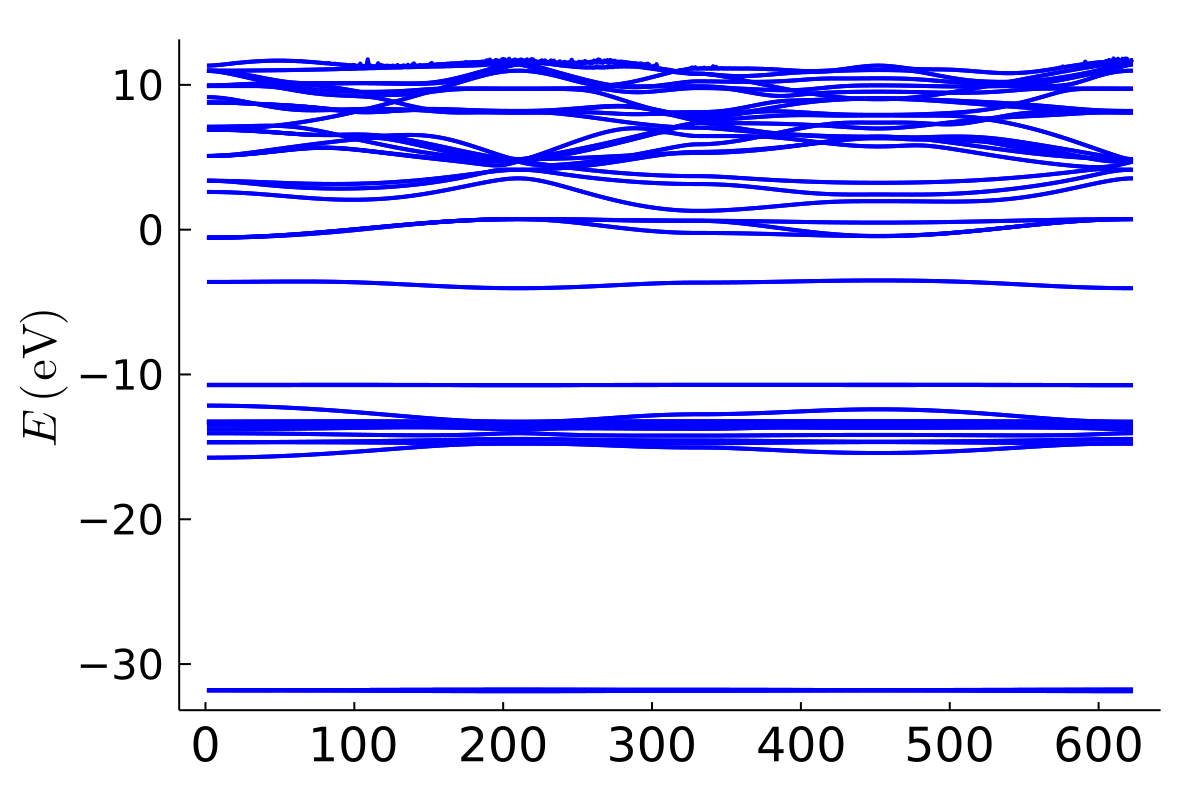

In [36]:
function plot_bands(path)
    (k, E, occ) = parse_xml(path)
    p = plot(E', lc = :blue, lw=2, label="", fmt=:png, dpi=200)
    plot!(p, ylabel = L"E \,\, \textrm{(eV)}", grid = false)
    plot!(p, xtickfontsize=16, ytickfontsize=14, yguidefontsize=16, margin=3mm)
    return p
end
plot_bands("vasprun.xml")

The result sort of sucks. We're missing quite a few ingredients.

# The Valence Band Maximum

Next, let's try computing the reference point (i.e., the valence band maximum).

In [37]:
function compute_band_props(E, occ)
    # Occupied bands are those with 1 in the occupations
    occupied = findall(==(1), occ)
    occupied_bands = map(i->i[1], occupied)
    # Unoccupied bands are those with 0 in the occupations
    unoccupied = findall(==(0), occ)
    unoccupied_bands = map(i->i[1], unoccupied)
    # Maximum occupied and minimum unoccupied bands
    max_vb = maximum(occupied_bands)
    min_cb = minimum(unoccupied_bands)
    # Compute vbm and cbm and band gap
    vbm = maximum(E[max_vb, :])
    cbm = minimum(E[min_cb, :]) 
    Eg = (cbm - vbm)*1000
    println("Band Gap: $Eg meV")
    println("CBM: $cbm eV")
    println("VBM: $vbm eV")

    return vbm, cbm, max_vb, min_cb
end

compute_band_props (generic function with 1 method)

## Plotting

Let's try plotting what we have so far once again

Band Gap: 17.29999999999965 meV
CBM: 4.2966 eV
VBM: 4.2793 eV


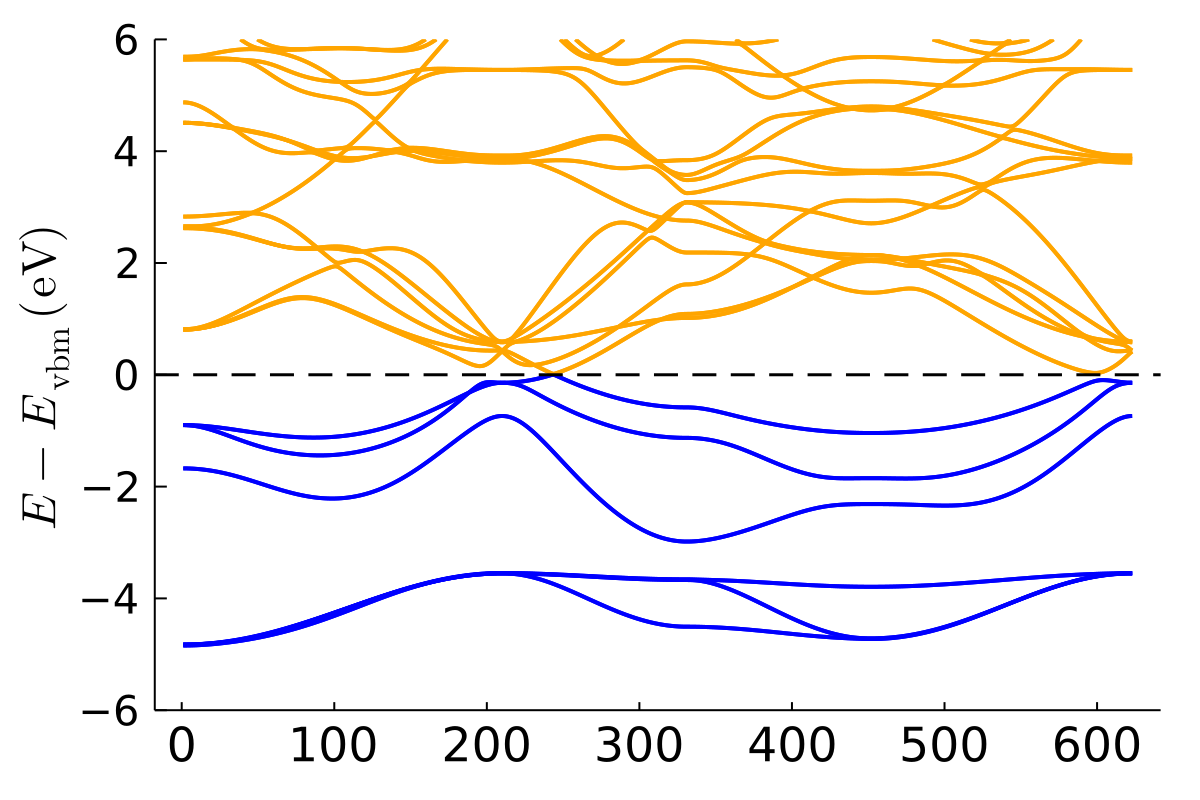

In [38]:
function plot_bands(path)
    (k, E, occ) = parse_xml(path)
    # Compute linearized k and plot
    (vbm, cbm, max_vb, min_cb) = compute_band_props(E, occ)
    p = plot(E[1:max_vb, :]'.- vbm, lc = :blue, lw=2, label="", fmt=:png, dpi=200)
    plot!(p, E[min_cb:end, :]'.- vbm, lc = :orange, lw=2, ylim=(-6,6), label="")
    # Plot reference energy and symmetry lines
    plot!(p, [0], seriestype=:hline, linestyle=:dash, lw=1.5, label="", linecolor=:black)
    plot!(p, ylabel =L"E - E_{\textrm{vbm}} \, \textrm{(eV)}", grid = false)
    plot!(p, xtickfontsize=16, ytickfontsize=14, yguidefontsize=16, margin=3mm)
    return p
end
plot_bands("vasprun.xml")

Much better! But something is still missing.

# Identifying the High Symmetry Points

The last step is to identify the high-symmetry points alone the band path.

In [40]:
function compute_kx(k)
    n_kpts = size(k, 2)
    # Allocate Arrays
    kx = zeros(n_kpts)
    # When symm[n] is true, it means k[n] is a high symm point
    symm = fill(false, n_kpts)
    symm[1] = true # First point is always high symmetry

    # Calculate stuff for the first step
    k_tmp = k[:,2] - k[:,1]
    dk_tmp = sqrt(k_tmp ⋅ k_tmp)

    # Temporary Arrays
    k1 = Vector{Float64}(undef, 3)
    k2 = Vector{Float64}(undef, 3)

    for n in 2:n_kpts
        k_tmp = k[:,n] - k[:,n-1] 
        dk = sqrt(k_tmp ⋅ k_tmp)
        # If there's a large jump, the path is discontinuous and we overlay the points
        if dk > 5*dk_tmp
            kx[n] = kx[n-1]
        elseif dk > 1e-5 # normal case: points separated by small delta
            kx[n] = kx[n-1] + dk
            dk_tmp = dk
        else # points separated by delta almost zero, add to path but don't save delta
            kx[n] = kx[n-1] + dk
        end
        # Then we determine symmetry
        if k[:,n] ⋅ k[:,n] < 1e-9 # gamma point is high symm
            symm[n] = true
        elseif n == n_kpts
            symm[n] = true # Last point is also a high symmetry point
        else
            k1 = k[:,n] - k[:,n-1]
            k2 = k[:,n+1] - k[:,n]
            cos_theta = (k1⋅k2)/sqrt(k1⋅k1)/sqrt(k2⋅k2)
            # If the path changes direction then it's a high symm point
            if abs(cos_theta - 1) > 1.0e-4
                symm[n] = true
            end
        end
    end
    
    symm_kx = kx[symm]
    symm_k = k[:,symm]

    for i in eachindex(symm_kx)
        println("High Symmetry Point $(symm_k[:,i]) at kx = $(symm_kx[i])")
    end

    return kx, symm_kx
    
end

compute_kx (generic function with 1 method)

## Plotting
Let's try plotting what we have one final time

High Symmetry Point [0.5, 0.5, 0.5] at kx = 0.0
High Symmetry Point [0.0, 0.0, 0.0] at kx = 0.8660254037844379
High Symmetry Point [0.0, 0.5, 0.0] at kx = 1.3660254037844337
High Symmetry Point [0.5, 0.5, 0.0] at kx = 1.8660254037844288
High Symmetry Point [0.0, 0.0, 0.0] at kx = 2.5731321849709867
Band Gap: 17.29999999999965 meV
CBM: 4.2966 eV
VBM: 4.2793 eV


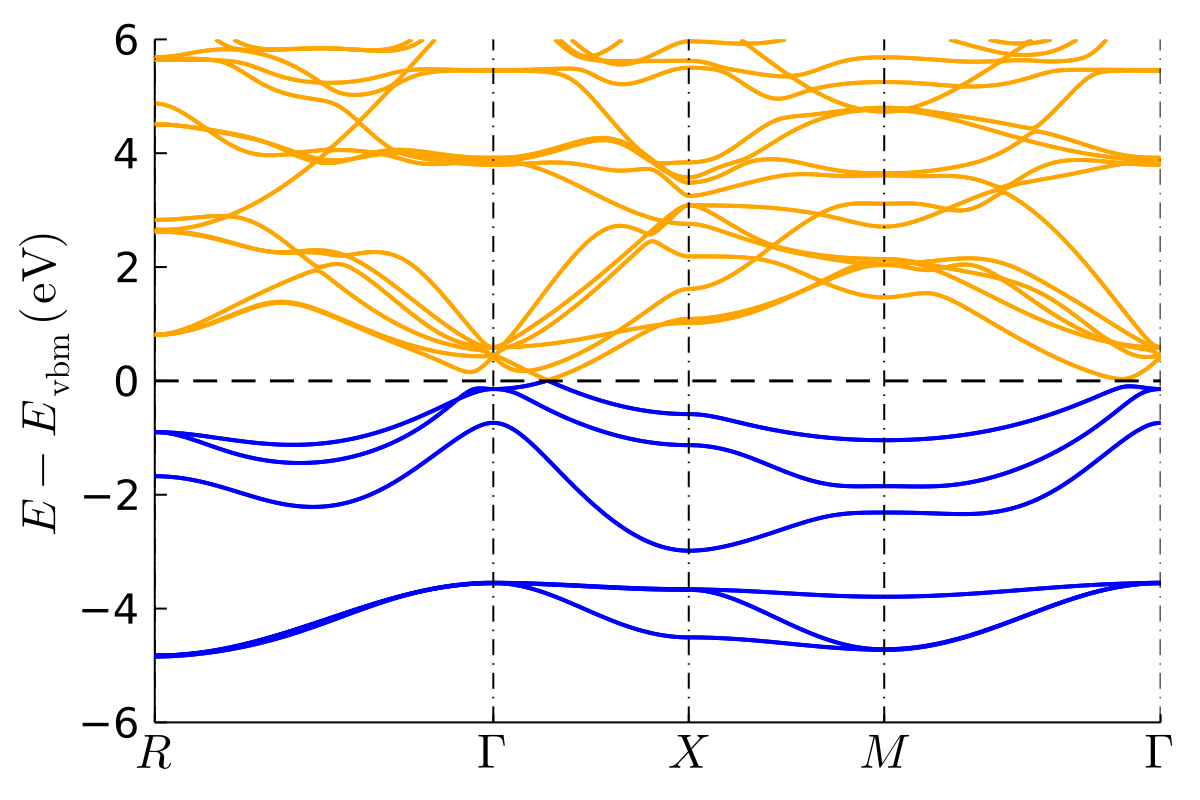

In [41]:
function plot_bands(path)
    (k, E, occ) = parse_xml(path)
    # Compute linearized k and plot
    kpath = [L"R", L"\Gamma", L"X", L"M", L"\Gamma"]
    (kx, symm)  = compute_kx(k)
    (vbm, cbm, max_vb, min_cb) = compute_band_props(E, occ)
    p = plot(kx, E[1:max_vb, :]'.- vbm, lc = :blue, lw=2, label="", fmt=:png, dpi=200)
    plot!(p, kx, E[min_cb:end, :]'.- vbm, lc = :orange, lw=2, ylim=(-6,6), label="")
    # Plot reference energy and symmetry lines
    plot!(p, [0], seriestype=:hline, linestyle=:dash, lw=1.5, label="", linecolor=:black)
    plot!(p, symm, seriestype=:vline, linestyle=:dashdot, lw=1, label="", linecolor=:black)
    plot!(p, ylabel = L"E - E_{\textrm{vbm}} \, \textrm{(eV)}", xticks = (symm, kpath), grid = false, xlim=(minimum(kx), maximum(kx)))
    plot!(p, xtickfontsize=16, ytickfontsize=14, yguidefontsize=16, margin=3mm)
    return p
end
plot_bands("vasprun.xml")

There we go!